# Customer churn in telecommunication
Churn means a customer used to spend a company but no longer do so. Analyzing customer churn is vital as it directly impacts revenue and a company's long-term sustainability. Understanding the reasons behind churn and implementing effective retention strategies is crucial in this competitive landscape, ensuring telecom companies can thrive and maintain their customer base.



## Data dictionary
- Target: Churn (customers who left within last month)
- Indepedent variables:
     1. Demographics: gender, senior citizen, partner, dependents   
     2. Services that customers have signed up for: phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
     3. Customer account information: tenure, contract, payment method, paperless billing, monthly charges, total charges
- Source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

## Setup
I used VS Code to take advantage of its workplace function, so I can use relative path instead of absolute path in my analysis, which makes this data science more portable. You can follow the documentation from VS code to set up the environment [here ](https://code.visualstudio.com/docs/datascience/data-science-tutorial).

After setting up the environment, you can install more libraries to your environment doing the following:
1. Go to Miniconda prompt
2. Type 'conda activate <name_of_your_environment>' (Package will be installed in a contained environment so that it won't mess up with other projects)
3. Type 'conda install <package_name>'

Import libraries in VS code.   

In [1]:
# organization
import os

# data manupilation & visaulziation for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# handle imbalanced classifcation
# PS: need sklearn version 1.2.2 to avoid error, 1.3.0 got error; install with command 'conda install imbalanced-learn'
import imblearn            
from collections import Counter
from imblearn.over_sampling import SMOTE  # oversampling
from imblearn.pipeline import Pipeline

# modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from xgboost import XGBClassifier

import tensorflow as tf     # need 2.4.0 or below for feature importance
from tensorflow import keras
from tensorflow.keras import layers

# explain model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from sklearn.inspection import PartialDependenceDisplay

# folder
folder_input = '02_input'

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Show the version of packages used in this notebook, so that others can replicate the package versions to avoid from running into error.

In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.0.3
numpy==1.24.3
seaborn==0.12.2
imblearn==0.10.1
tensorflow==2.10.0
keras.api._v2.keras==2.10.0
eli5==0.13.0
shap==0.42.1


Import data

In [3]:
org = pd.read_csv(os.path.join('..', folder_input, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))
org.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Basic dataset information

You could use [data wrangler extension](https://devblogs.microsoft.com/python/data-wrangler-release/) from VS Code to do basic data exploration, which could save a lot of time. For demonstration purpose, I continue to explore the data through the traditional coding way first.

In [4]:
org.shape


(7043, 21)

In [5]:
org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# any missing values
org.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
# unique value of categorical data
# check all unique value
colnames = org.select_dtypes(include=['object']).columns

for i in colnames:
    print(i, ": ", org[i].unique())

customerID :  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender :  ['Female' 'Male']
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges :  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn :  ['No' 'Yes']


Total Charges should be numerical data. But I got an error when attempting to change it from object to numeric, because a few of its value is ' ' instead of 0 when customers have 0 tenure. CustomerID also doesn't seem to have much information, so let's delete it too.

In [8]:
# customer id
org = org.drop('customerID', axis=1)    # 1 = column, 0 = row

# total charges: change from " " to 0
org['TotalCharges'] = org['TotalCharges'].str.replace(" ", "0", case=False, regex=False)
org = org.astype({'TotalCharges': 'float64'})

## Exploratory data analysis (EDA) & Feature Engineering

Let's explore the target variable first. Only one forth of customers are churned, meaning this is an imbalanced binary classification problem.

In [9]:
cnt = org.Churn.value_counts()
print('Count of Churn \n', cnt, '\n')

cnt_perent = cnt/org.shape[0] * 100
print('Percentage of Churn \n', cnt_perent)


Count of Churn 
 Churn
No     5174
Yes    1869
Name: count, dtype: int64 

Percentage of Churn 
 Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64


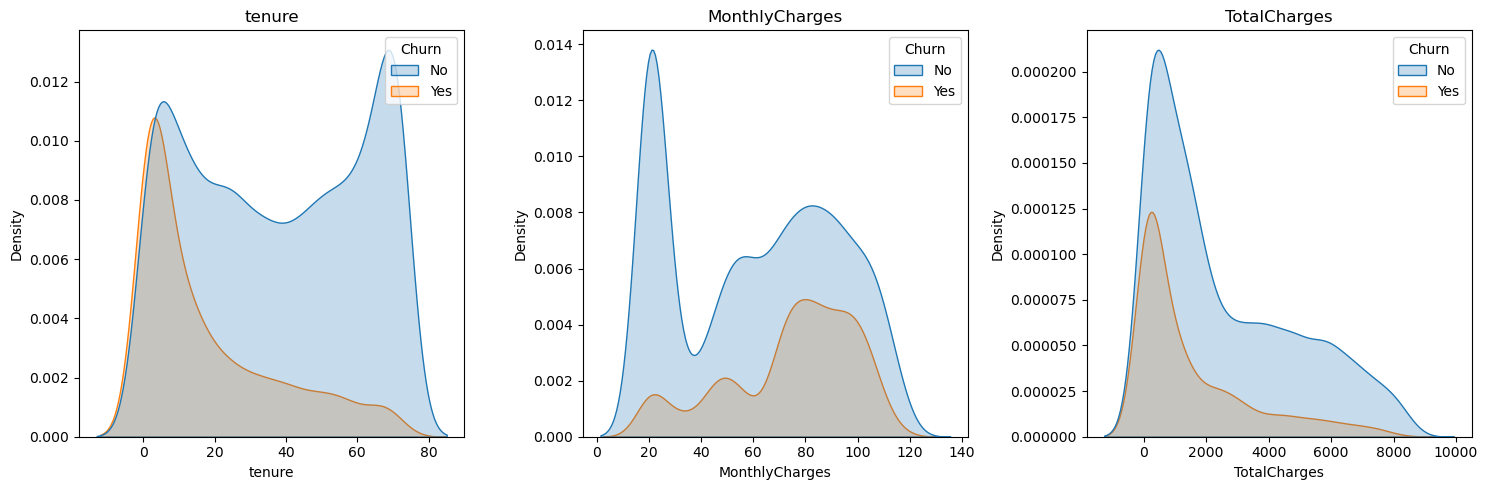

In [10]:
# numerical
def plot_numerical(variables, nrow, ncol, size):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i, variable in enumerate(variables):
        ax = axes[i]
        sns.kdeplot(data=org, x=variable, hue='Churn', fill=True, ax=ax)
        ax.set_title(variable)

    plt.tight_layout()
    plt.show()


# plot
var_num = ['tenure', 'MonthlyCharges', 'TotalCharges']
plot_numerical(var_num, 1, 3 ,5)

Relationship between tenure, monthly charges and total charges

The figure layout has changed to tight


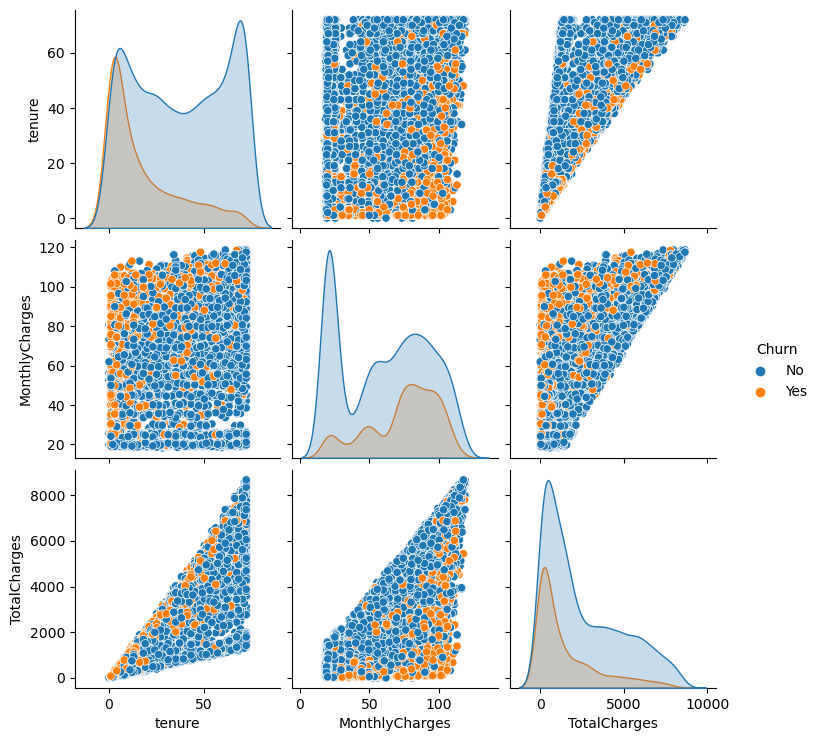

In [11]:
sns.pairplot(org[var_num + ['Churn']], hue='Churn')

In [12]:
# check if their monthly charge ever changed

org['Tenure_Calculated_Diff'] = org['TotalCharges']/org['MonthlyCharges'] - org['tenure']

# confirm it's different
print('Distribution of the difference between the tenure column and the calculated tenure')
print(org['Tenure_Calculated_Diff'].describe())

# # visulization
# sns.kdeplot(data=check, x='Tenure_calculated', hue='Churn', fill=True)
# plt.title('Distribution of difference between tenure column and the calculated tenure')

# indicate contract change
org['Is_MonthlyCharges_Changed'] = ((org['Tenure_Calculated_Diff'] < -0.5) | (org['Tenure_Calculated_Diff'] > 0.5)).astype('int')


Distribution of the difference between the tenure column and the calculated tenure
count    7043.000000
mean        0.002282
std         1.135584
min        -6.941748
25%        -0.517380
50%         0.000000
75%         0.488900
max         7.706941
Name: Tenure_Calculated_Diff, dtype: float64


### Demographics 

In [13]:
# function to plot data for EDA

# categorical
def plot_category(variables, nrow, ncol, size, rotation):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()        # cannot go to the second row of fig without this
    
    for i, variable in enumerate(variables):
        ax = sns.countplot(data=org, x=variable, hue='Churn', ax=axes[i])
        # plt.xticks(rotation=rotation)
        
        # Calculate percentages and annotate
        total = len(org)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.15
            y = p.get_height() + 10
            ax.annotate(percentage, (x, y), fontsize=10)
        
        ax.set_title(variable)
        ax.tick_params(axis='x', rotation=rotation)

    plt.tight_layout()
    plt.show()




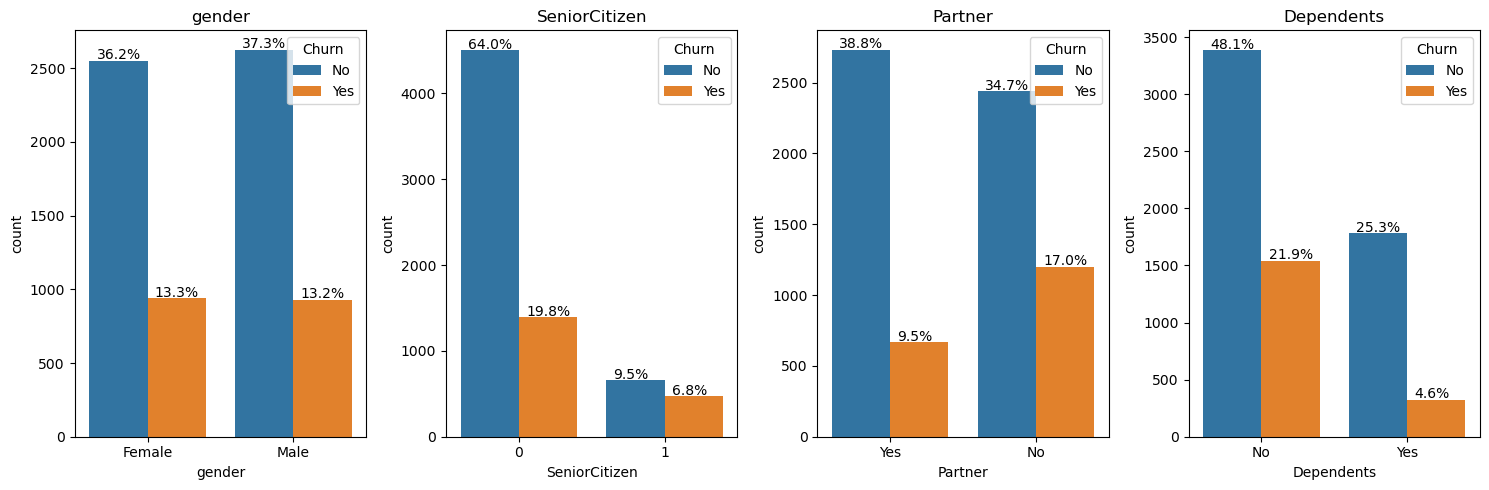

In [14]:
var_demo = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plot_category(var_demo, 1, 4, 5, 0)


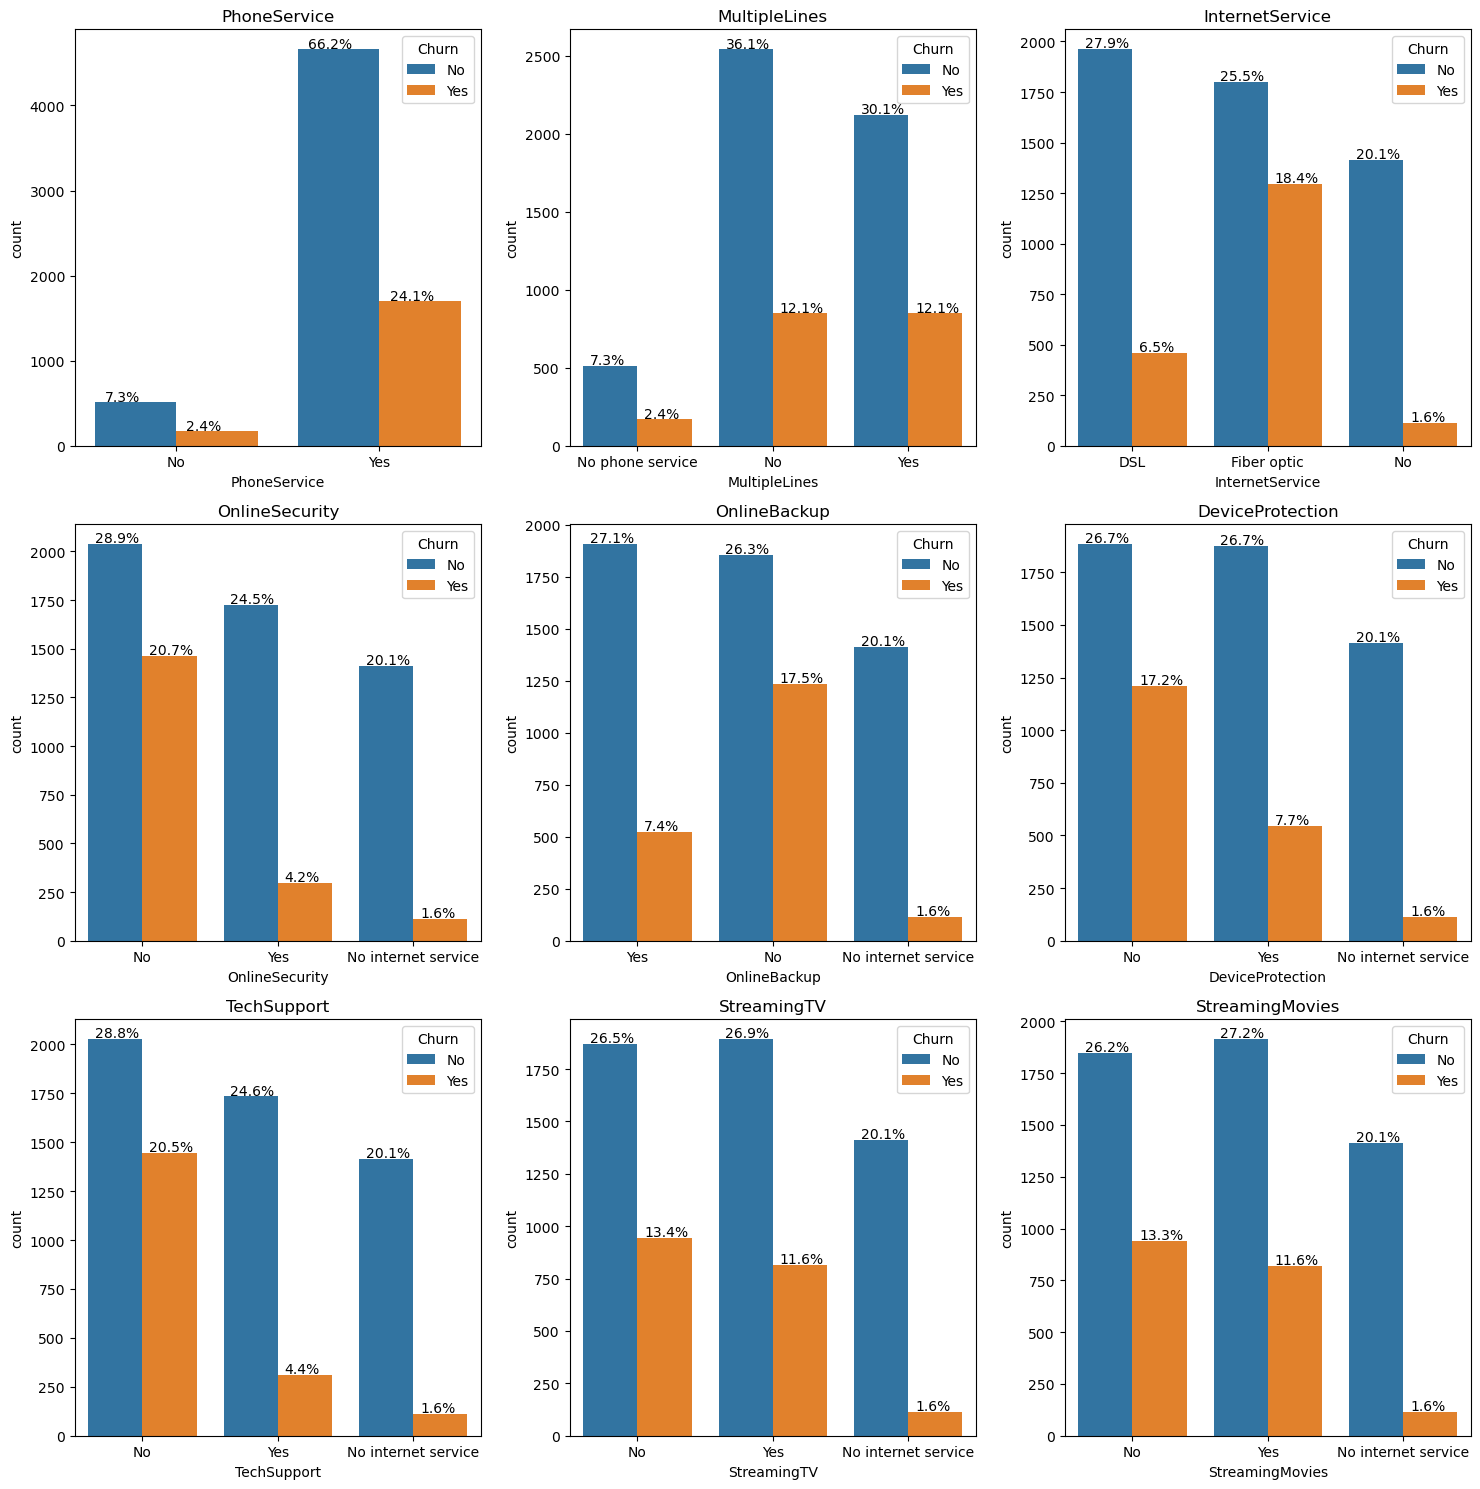

In [15]:
var_service = [
    'PhoneService', 
    'MultipleLines', 
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies'
    ]

plot_category(var_service, 3, 3, 15, 0)

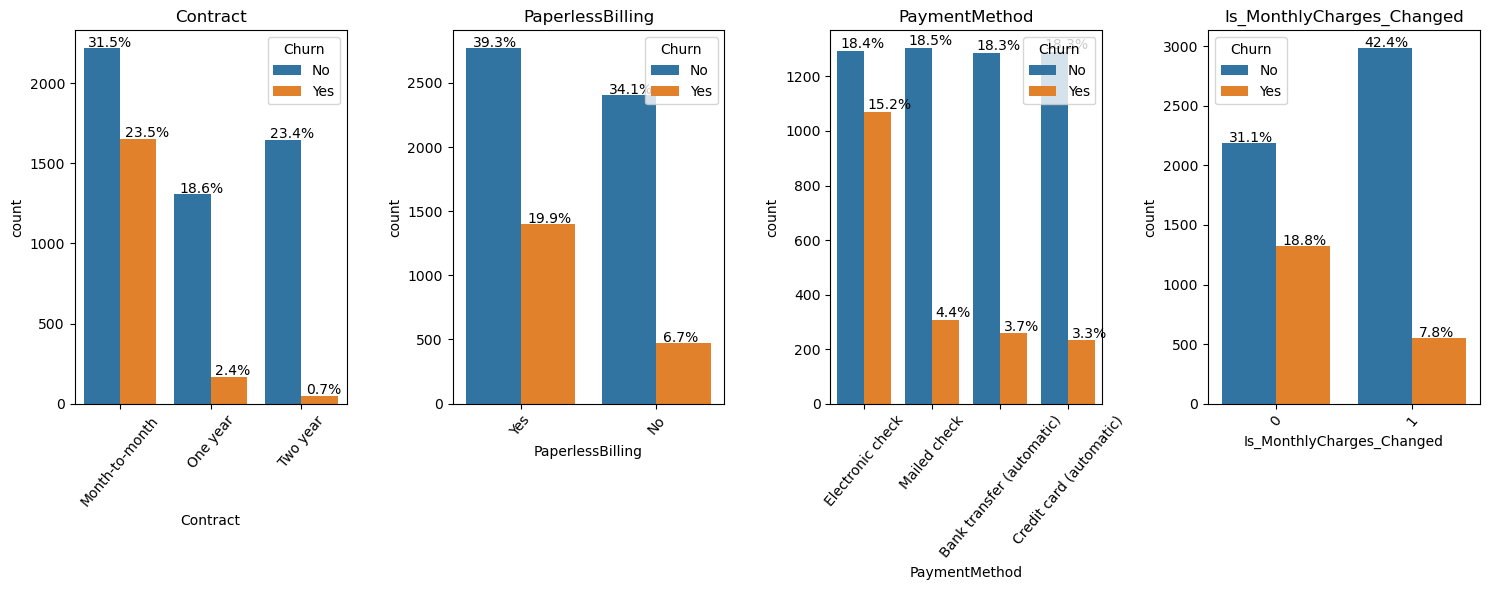

In [16]:
var_account_cat = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Is_MonthlyCharges_Changed']
plot_category(var_account_cat, 1, 4, 6, 50)

Monthly Charges vs services

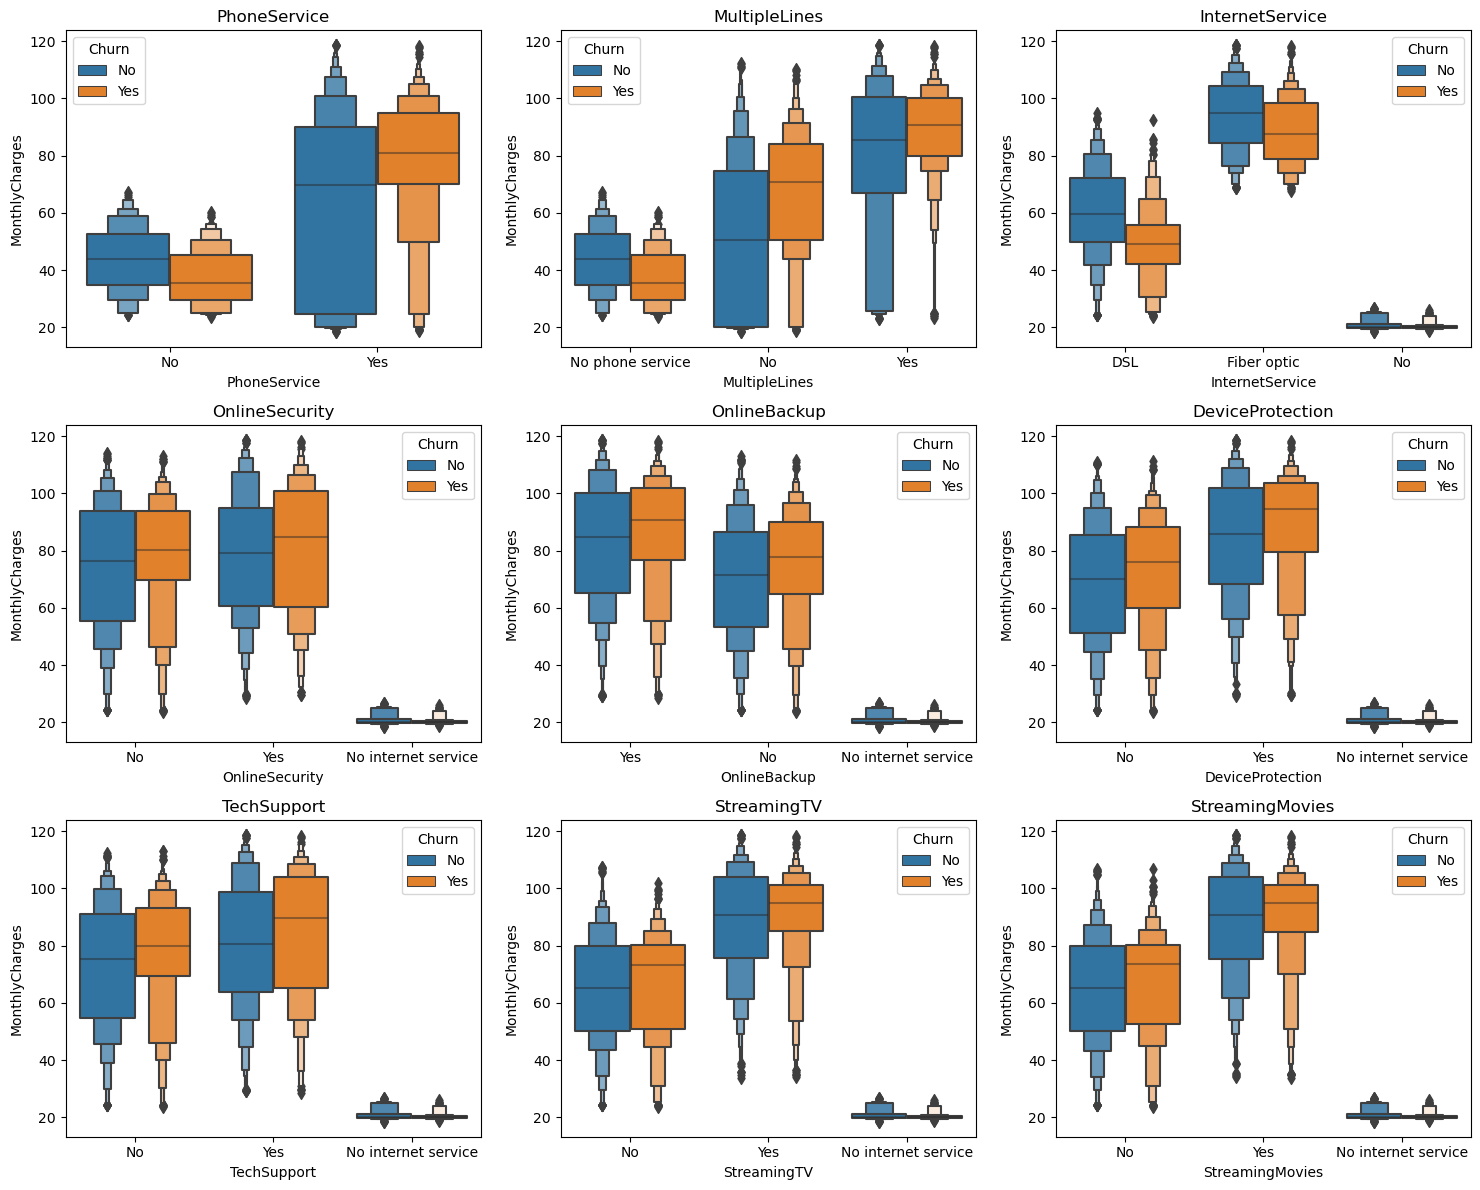

In [17]:
def plot_charges(variables, nrow, ncol, size, rotation):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i, variable in enumerate(variables):
        ax = sns.boxenplot(data=org, x=variable, y='MonthlyCharges', hue='Churn', ax=axes[i])        
        ax.set_title(variable)
        ax.tick_params(axis='x', rotation=rotation)

    plt.tight_layout()
    plt.show()


# plot
plot_charges(var_service, 3, 3, 12, 0)

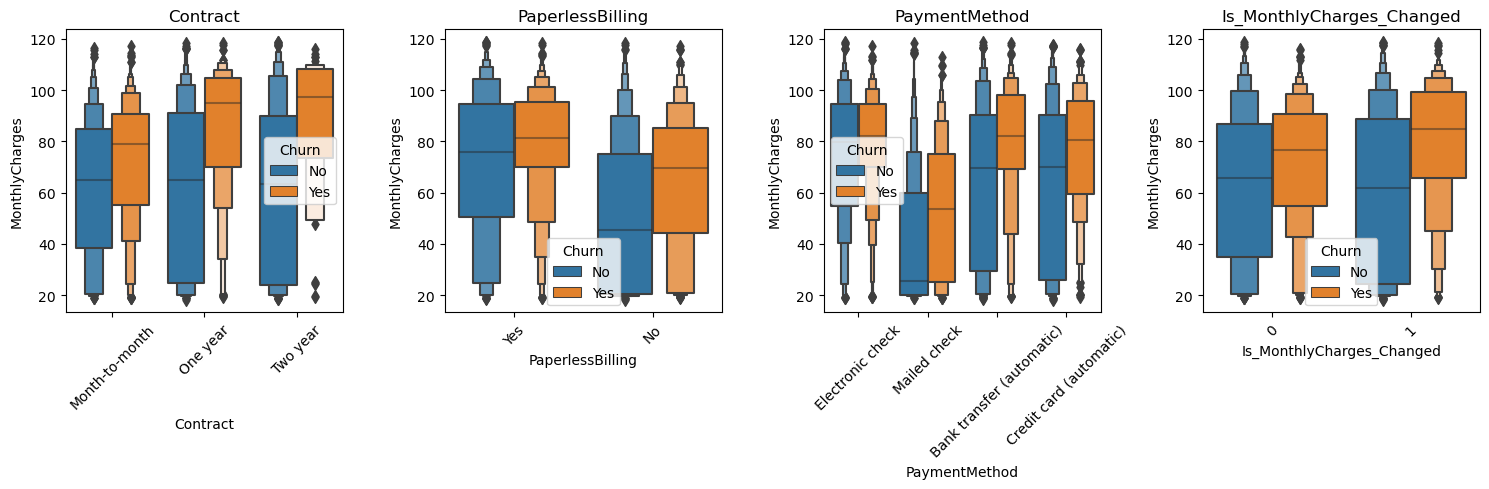

In [18]:
plot_charges(var_account_cat, 1, 4, 5, 45)

## Turn imbalanced data to balanced data

In [19]:
# encode categorical data
# Need numeric data for resampling
# PS: Use label encoder when there is no order within the categorical data
category_encoder = LabelEncoder()

var_cat = var_demo + var_service + var_account_cat + ['Churn']
for i in var_cat:
    org[i] = category_encoder.fit_transform(org[i])
    print(i,' : ',org[i].unique(),' = ', category_encoder.inverse_transform(org[i].unique()))

gender  :  [0 1]  =  ['Female' 'Male']
SeniorCitizen  :  [0 1]  =  [0 1]
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Is_MonthlyCharges_Changed  :  [0 1]  =  [0 1]
Churn  :  [0 1]  =  ['N

In [20]:
# resampling
# PS: sampling_strategy = 1 means over sample the minority to 100% of majority

over_sampler = SMOTE(sampling_strategy=1, random_state=0)

# seperate X and y from original dataset
X = org.copy()
y = X.pop('Churn')

X, y = over_sampler.fit_resample(X, y)
Counter(y)


Counter({0: 5174, 1: 5174})

Now the 'churn = yes' row is over-sampled to the same size of the 'churn = no' group.

## Models

### Create training and testing datasets

In [21]:
# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Preprocessing

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     10348 non-null  int32  
 1   SeniorCitizen              10348 non-null  int64  
 2   Partner                    10348 non-null  int32  
 3   Dependents                 10348 non-null  int32  
 4   tenure                     10348 non-null  int64  
 5   PhoneService               10348 non-null  int32  
 6   MultipleLines              10348 non-null  int32  
 7   InternetService            10348 non-null  int32  
 8   OnlineSecurity             10348 non-null  int32  
 9   OnlineBackup               10348 non-null  int32  
 10  DeviceProtection           10348 non-null  int32  
 11  TechSupport                10348 non-null  int32  
 12  StreamingTV                10348 non-null  int32  
 13  StreamingMovies            10348 non-null  int

In [23]:
# test keep numerical data
# encoder
num_encoder = MinMaxScaler()
num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[var_num]))
num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[var_num]))

#encoding removed index; put it back
num_cols_train.index = X_train.index
num_cols_test.index = X_test.index

# add back colnames
num_cols_train.columns = num_encoder.get_feature_names_out() + '_Scaled'
num_cols_test.columns = num_encoder.get_feature_names_out() + '_Scaled'

# # Remove numerical  columns (will replace with encoding)
# cat_X_train = X_train.drop(var_num, axis=1)
# cat_X_test = X_test.drop(var_num, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([X_train, num_cols_train], axis=1)
X_test = pd.concat([X_test, num_cols_test], axis=1)


X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Tenure_Calculated_Diff,Is_MonthlyCharges_Changed,tenure_Scaled,MonthlyCharges_Scaled,TotalCharges_Scaled
4053,1,1,0,0,11,1,2,0,2,2,...,0,0,0,60.25,662.95,0.003320,0,0.152778,0.417910,0.076335
6829,1,0,1,1,8,1,0,2,1,1,...,2,0,1,19.60,125.00,-1.622449,1,0.111111,0.013433,0.014393
1141,1,0,0,1,6,1,0,2,1,1,...,0,1,3,20.20,98.35,-1.131188,1,0.083333,0.019403,0.011324
845,0,0,1,1,15,1,0,2,1,1,...,1,0,3,20.55,295.95,-0.598540,1,0.208333,0.022886,0.034077
3497,0,1,1,0,2,1,0,1,0,0,...,0,1,2,69.30,153.80,0.219336,0,0.027778,0.507960,0.017709


In [24]:
# # numerical data

# # encoder
# num_encoder = MinMaxScaler()
# num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[var_num]))
# num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[var_num]))

# #encoding removed index; put it back
# num_cols_train.index = X_train.index
# num_cols_test.index = X_test.index

# # add back colnames
# num_cols_train.columns = num_encoder.get_feature_names_out()
# num_cols_test.columns = num_encoder.get_feature_names_out()

# # Remove numerical  columns (will replace with encoding)
# cat_X_train = X_train.drop(var_num, axis=1)
# cat_X_test = X_test.drop(var_num, axis=1)

# # Add one-hot encoded columns to numerical features
# X_train = pd.concat([cat_X_train, num_cols_train], axis=1)
# X_test = pd.concat([cat_X_test, num_cols_test], axis=1)


# X_train.head()

### Model training and evaluation

In [25]:
# model evaluation
def model_evaluation(classification_model, X_test, y_test):
    # prediction
    preds = classification_model.predict(X_test)
    preds = (preds >= 0.5).astype('int')            # handle tensorflow's output
    
    # accuracy score
    print('Accuracy score: \n', accuracy_score(y_test, preds), '\n')
    
     # classification report
    print('Classification matrix: \n', classification_report(y_test, preds))
    
    # confusion matrix
    cf_matrix = confusion_matrix(y_test, preds)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percent = ['{0:.0%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percent)]
    labels = np.asarray(labels).reshape(2, 2)
    
    sns.set(rc={'figure.figsize':(5,4)})
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
                

### Random forest

In [44]:
# feature selection
feature_not_selected = [
    'StreamingMovies',
    'MultipleLines',
    'SeniorCitizen',
    'StreamingTV',
    'gender'
    ] + var_num


# remove columns
X_train_rf = X_train.drop(feature_not_selected, axis=1)    # axis=1 for columns
X_test_rf = X_test.drop(feature_not_selected, axis=1)

# model
rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf_model = rf.fit(X_train_rf, y_train)


Accuracy score: 
 0.8484731349052957 

Classification matrix: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1290
           1       0.83      0.87      0.85      1297

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587



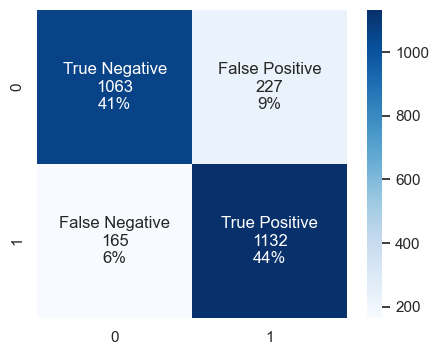

In [45]:
model_evaluation(rf_model, X_test_rf, y_test)

In [46]:
# permutation importance
no_of_features = X_train_rf.shape[1]

perm = PermutationImportance(rf_model, random_state=1).fit(X_test_rf, y_test)
eli5.show_weights(perm, top=no_of_features, feature_names = X_test_rf.columns.tolist())   #default show 20 variables

Weight,Feature
0.1089 ± 0.0161,Contract
0.0478 ± 0.0124,MonthlyCharges_Scaled
0.0435 ± 0.0051,TechSupport
0.0405 ± 0.0025,OnlineSecurity
0.0207 ± 0.0032,OnlineBackup
0.0196 ± 0.0061,tenure_Scaled
0.0169 ± 0.0022,TotalCharges_Scaled
0.0167 ± 0.0084,Is_MonthlyCharges_Changed
0.0152 ± 0.0032,PaymentMethod
0.0118 ± 0.0033,Tenure_Calculated_Diff


In [1]:
# # feature importance
# rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending= False)
# rf_importance

# # plot it
# sns.set(rc={'figure.figsize':(11,5)})
# sns.barplot(x = rf_importance.values,
#             y = rf_importance.index)

### XGBoost

In [ ]:
# feature selection
feature_not_selected = [
    'StreamingMovies',
    'MultipleLines',
    'SeniorCitizen',
    'StreamingTV',
    'gender',
    
    'MonthlyCharges_Scaled',
    'tenure_Scaled',
    'TotalCharges_Scaled'
    ]

# remove columns
X_train_xgb = X_train.drop(feature_not_selected, axis=1)    # axis=1 for columns
X_test_xgb = X_test.drop(feature_not_selected, axis=1)


# xgboost
# Outstanding: To experiment with scale_pos_weight on imbalanced data
xgb_model = XGBClassifier(n_estimators = 1000, random_state=0)
xgb_model.fit(
    X_train_xgb,
    y_train
)

Accuracy score: 
 0.8407421724004639 

Classification matrix: 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1290
           1       0.83      0.85      0.84      1297

    accuracy                           0.84      2587
   macro avg       0.84      0.84      0.84      2587
weighted avg       0.84      0.84      0.84      2587



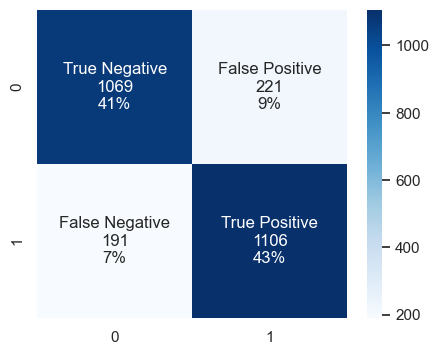

In [55]:
model_evaluation(xgb_model, X_test_xgb, y_test)

In [72]:
# permutation importance
no_of_features = X_train_xgb.shape[1]

perm = PermutationImportance(xgb_model, random_state=1).fit(X_test_xgb, y_test)
eli5.show_weights(perm, top=no_of_features, feature_names = X_test_xgb.columns.tolist())

Weight,Feature
0.0741 ± 0.0105,MonthlyCharges
0.0726 ± 0.0063,Contract
0.0543 ± 0.0046,tenure
0.0371 ± 0.0039,InternetService
0.0349 ± 0.0114,TotalCharges
0.0319 ± 0.0098,TechSupport
0.0253 ± 0.0042,Is_MonthlyCharges_Changed
0.0250 ± 0.0115,OnlineSecurity
0.0199 ± 0.0066,OnlineBackup
0.0197 ± 0.0058,Tenure_Calculated_Diff


In [74]:
# # feature importance
# xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending= False)
# xgb_importance

# # plot it
# sns.set(rc={'figure.figsize':(11,5)})
# sns.barplot(x = xgb_importance.values,
#             y = xgb_importance.index)

### Tensorflow

In [56]:
# feature selection
feature_not_selected = [
    'StreamingMovies',
    'MultipleLines',
    'SeniorCitizen',
    'StreamingTV',
    'gender'
    ] + var_num


# remove columns
X_train_tf = X_train.drop(feature_not_selected, axis=1)    # axis=1 for columns
X_test_tf = X_test.drop(feature_not_selected, axis=1)

In [68]:
# define model
# ie structure of the neural network

tf.random.set_seed(0)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# model
tf_model = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape = [X_train_tf.shape[1]]),   # non-linear
    layers.BatchNormalization(),
    layers.Dense(6, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),      # classification
])

# model compile
# tell model what to adjust to  
tf_model.compile(
    loss = keras.losses.binary_crossentropy,                   # for classification
    optimizer = keras.optimizers.Adam(learning_rate=0.03),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),         # what else to show in each epoch
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

# fit model 
history = tf_model.fit(
    X_train_tf, 
    y_train,
    validation_data=[X_test_tf, y_test], 
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
    )

Best Validation Loss: 0.3713
Best Validation Accuracy: 0.8315


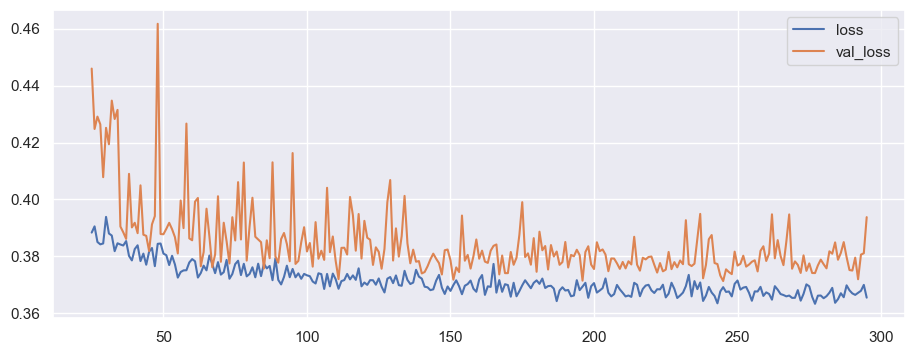

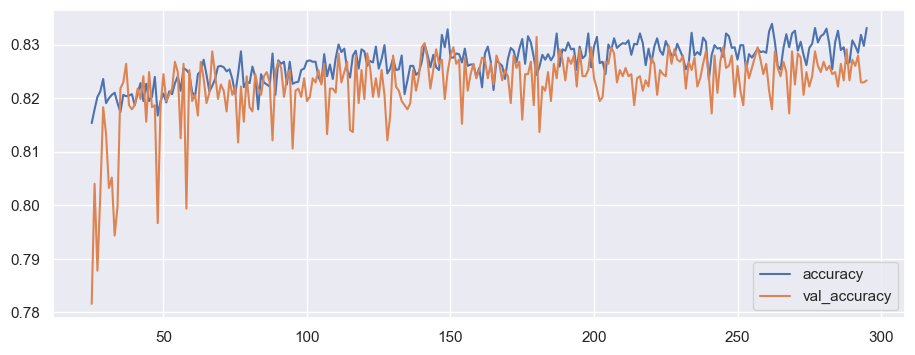

In [71]:
# observe overfitting/underfitting to adjust the model
sns.set(rc={'figure.figsize':(11,4)})

history_df = pd.DataFrame(history.history)
history_df.loc[25:, ['loss', 'val_loss']].plot()
history_df.loc[25:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

81/81 [==============================] - 0s 2ms/step
Accuracy score: 
 0.8264398917665249 

Classification matrix: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      1290
           1       0.82      0.83      0.83      1297

    accuracy                           0.83      2587
   macro avg       0.83      0.83      0.83      2587
weighted avg       0.83      0.83      0.83      2587



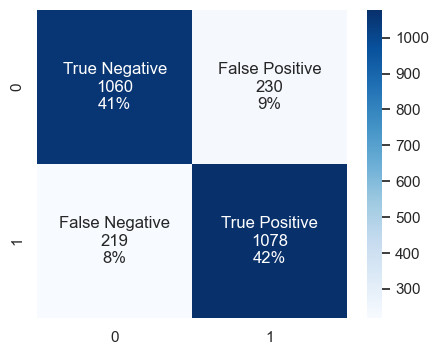

In [65]:
model_evaluation(tf_model, X_test_tf, y_test)

## SHAP (Machine learning explainability)

### Summary plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


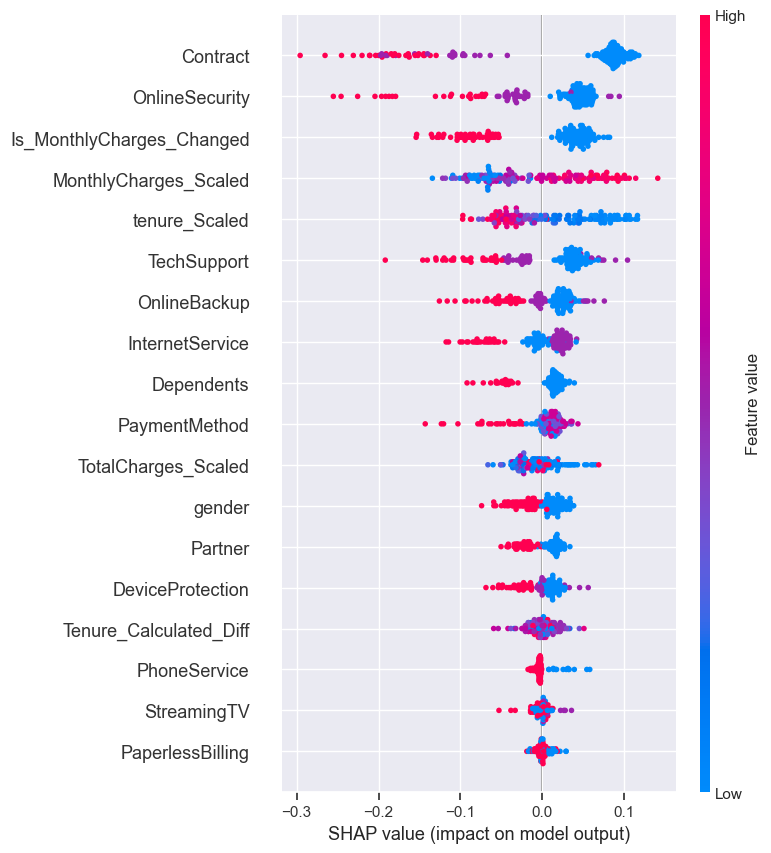

In [36]:
# For speed, we will calculate shap values on smaller subset of the validation data
# tips from kaggle learn
X_test_shap = X_test_rf[:150]

# shap explainer
# churn = 'yes' is labeled as 1, so it's shap_values[1]
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_shap)
shap.summary_plot(shap_values[1], X_test_shap)

### Partial dependence plots (1 dimension)

In [78]:
X_test_rf.shape
print(X_test_rf.columns)
print(var_num)
print(var_demo)
print(var_service)
print(var_account_cat)

Index(['Partner', 'Dependents', 'PhoneService', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Tenure_Calculated_Diff', 'Is_MonthlyCharges_Changed', 'tenure_Scaled',
       'MonthlyCharges_Scaled', 'TotalCharges_Scaled'],
      dtype='object')
['tenure', 'MonthlyCharges', 'TotalCharges']
['gender', 'SeniorCitizen', 'Partner', 'Dependents']
['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
['Contract', 'PaperlessBilling', 'PaymentMethod', 'Is_MonthlyCharges_Changed']


In [81]:
def plot_pdp_1D(variables, nrow, ncol, size):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i in range(len(variables)):         # Iterate over indices (because ax needs index too)
        PartialDependenceDisplay.from_estimator(rf_model, X_test_rf, [variables[i]], ax=axes[i])

    plt.tight_layout()
    plt.show()

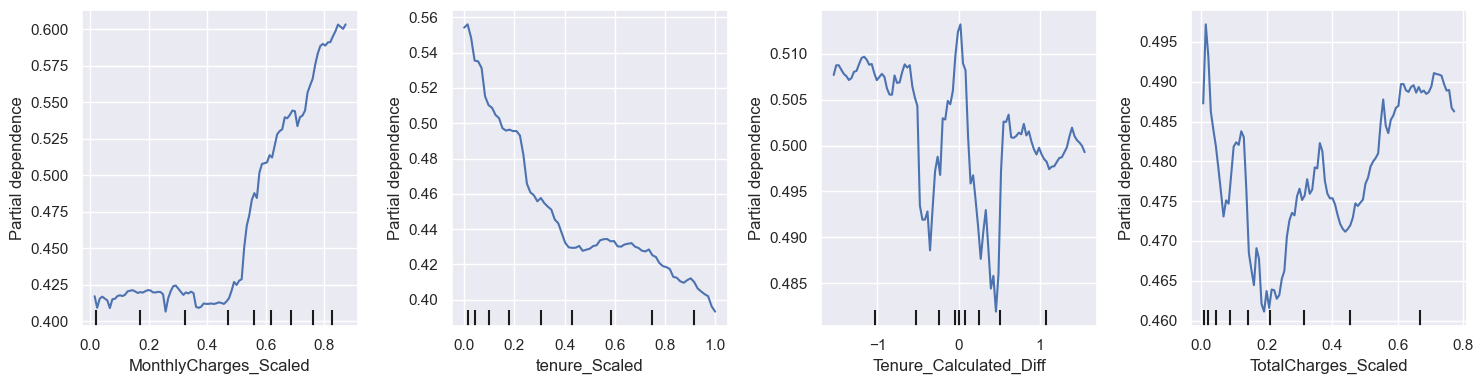

In [84]:
feature_names = ['MonthlyCharges_Scaled', 'tenure_Scaled', 'Tenure_Calculated_Diff', 'TotalCharges_Scaled']
plot_pdp_1D(feature_names, 1, 4, 4)

In [43]:
# calculate the tipping point

def tipping_point(varible, scaled_number):
    tipping = (X_train[varible].max() - X_train[varible].min()) * scaled_number + X_train[varible].min()
    print('Tipping point for {}: {}'.format(varible, tipping))
    
tipping_point('MonthlyCharges', 0.5)
tipping_point('tenure', 0.4)
tipping_point('TotalCharges', 0.2)

Tipping point for MonthlyCharges: 68.5
Tipping point for tenure: 28.8
Tipping point for TotalCharges: 1736.96


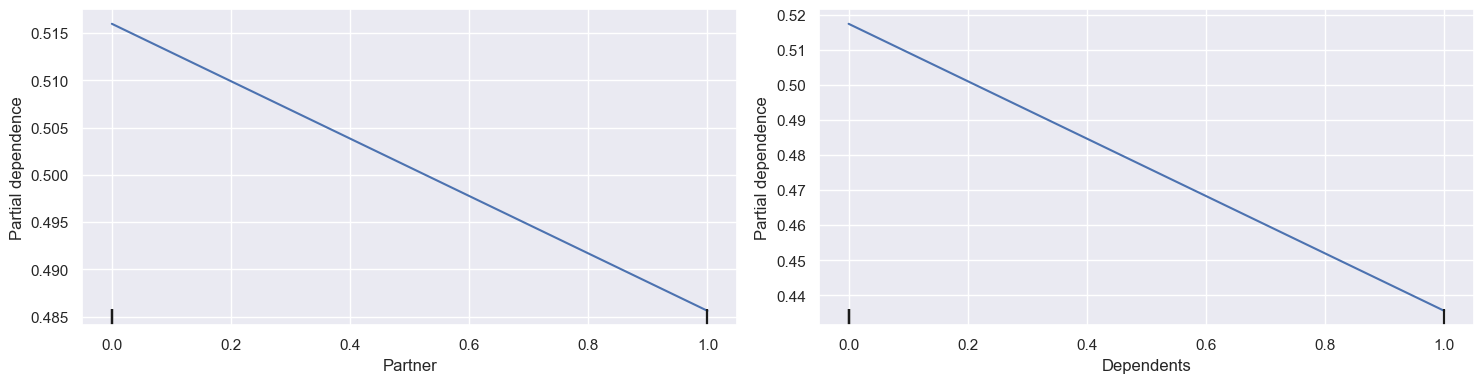

In [86]:
feature_names = ['Partner', 'Dependents']
plot_pdp_1D(feature_names, 1, 2, 4)

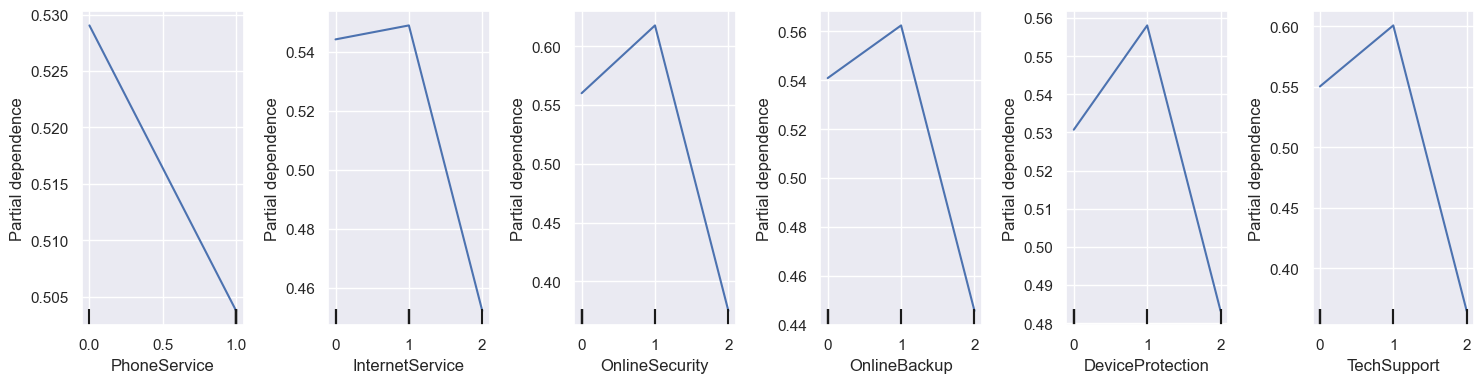

In [85]:
feature_names = [
    'PhoneService', 
    # 'MultipleLines', 
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    # 'StreamingTV', 
    # 'StreamingMovies'
    ]

plot_pdp_1D(feature_names, 1, 6, 4)

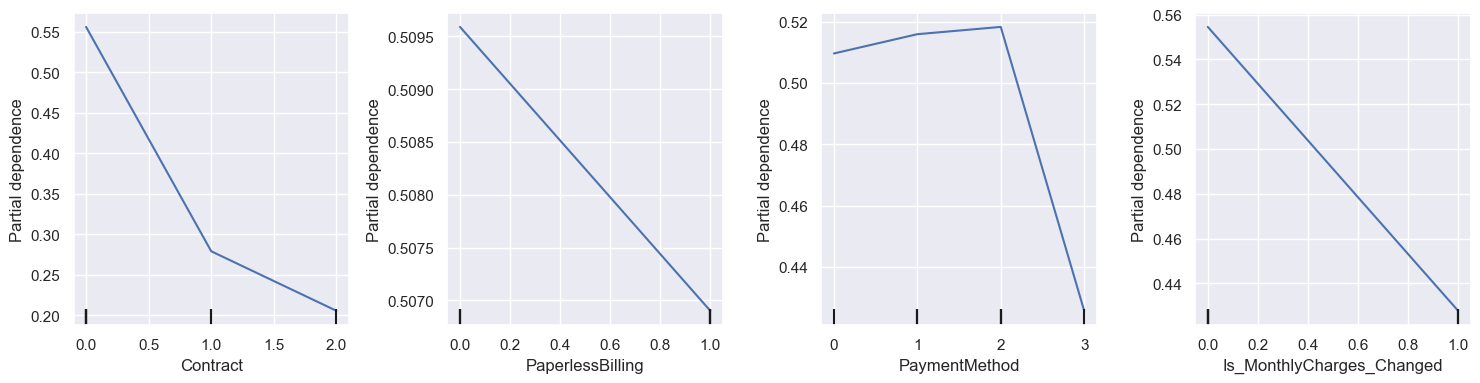

In [87]:
feature_names = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Is_MonthlyCharges_Changed']
plot_pdp_1D(feature_names, 1, 4, 4)

### Partial dependence plot (Monthly charges vs other factors)

In [46]:
def pdp_2D(feature_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(rf_model, X_test_rf, [('MonthlyCharges_Scaled', feature_name)], ax=ax)
    
    
fig, ax = plt.subplots(1, 3, figsize=(5, 5))
ax = ax.flatten()

for i in range(len(X_train_rf.columns)):         # Iterate over indices (because ax needs index too)
    PartialDependenceDisplay.from_estimator(rf_model, X_test_rf, [X_train_rf.columns[i]], ax=ax[i])

plt.tight_layout()
plt.show()

ValueError: Feature 'PhoneServiceStreamingTV' not in feature_names

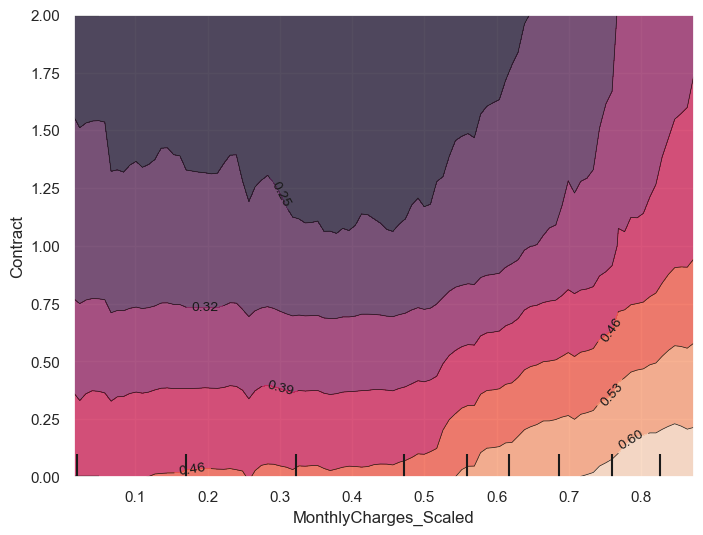

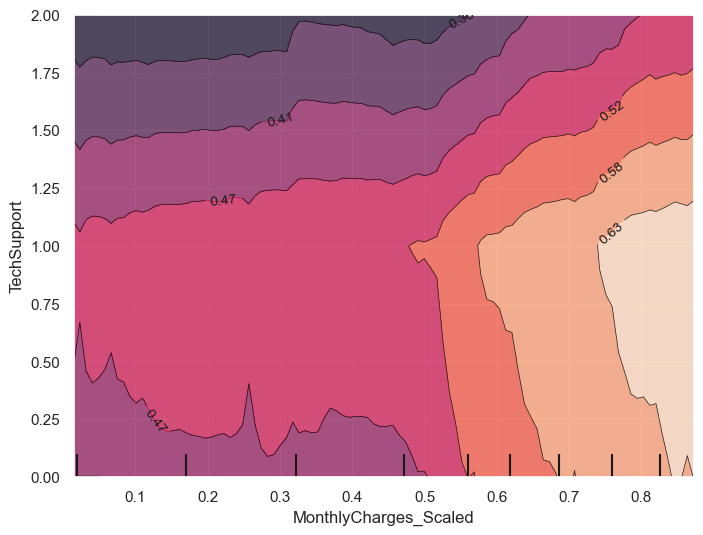

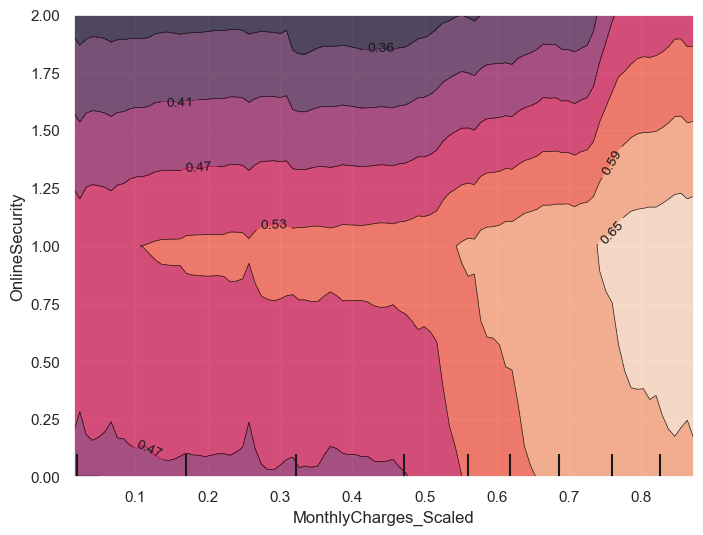

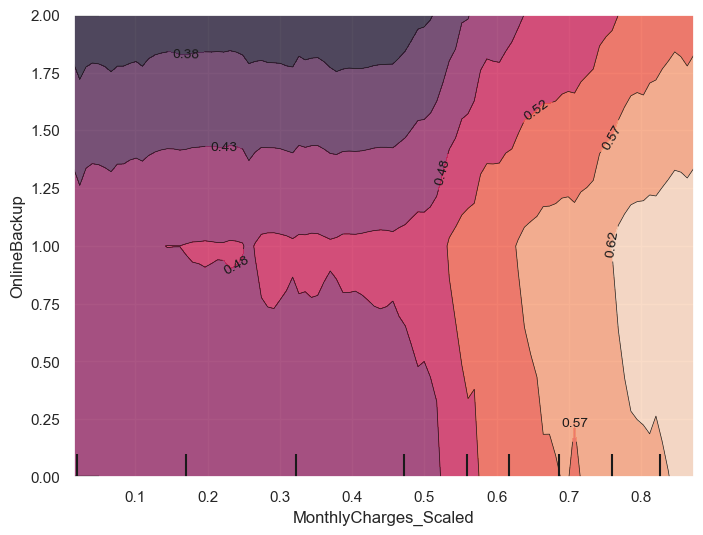

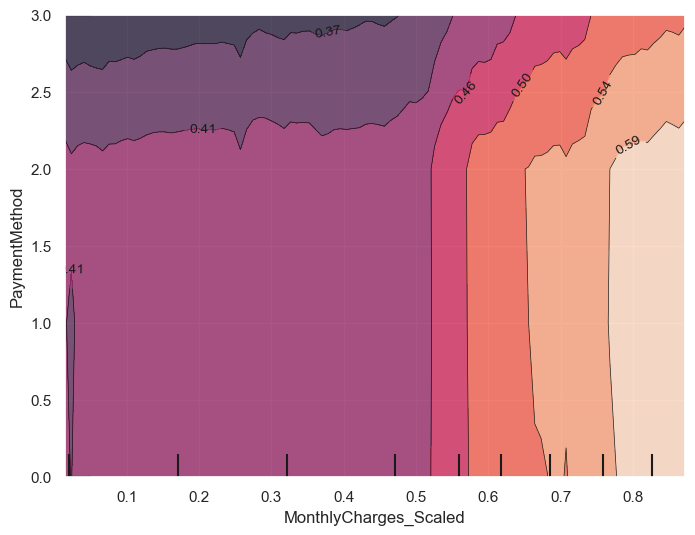

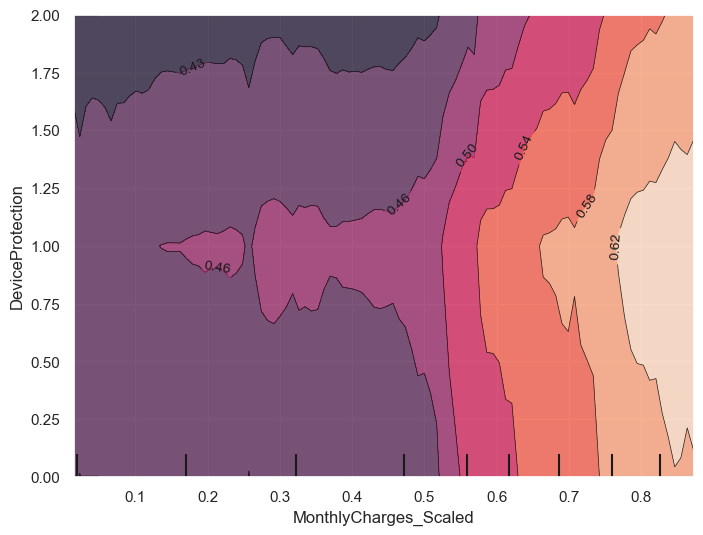

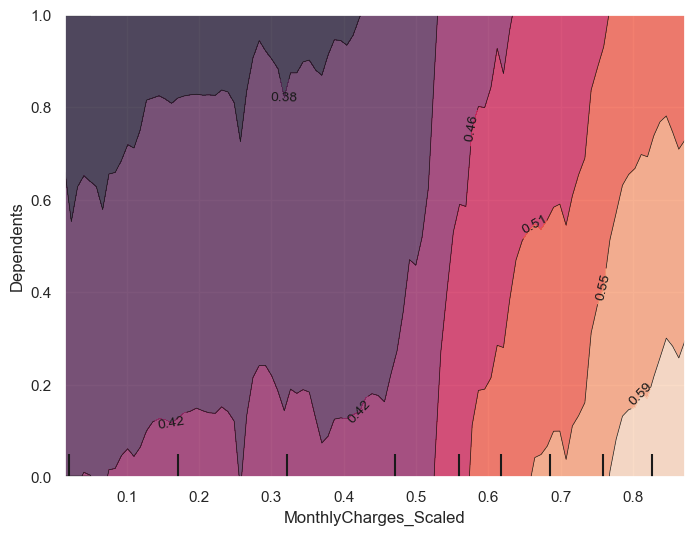

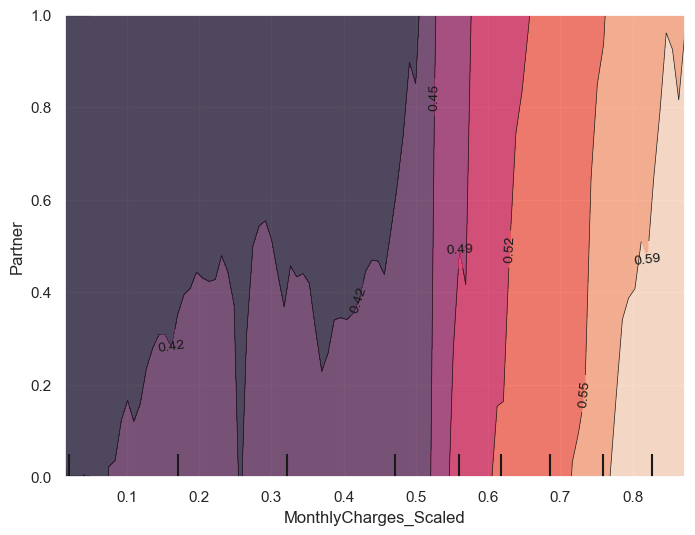

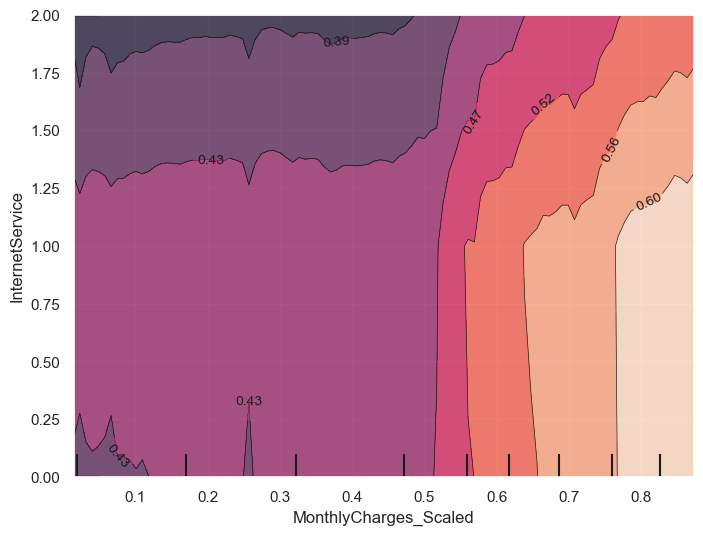

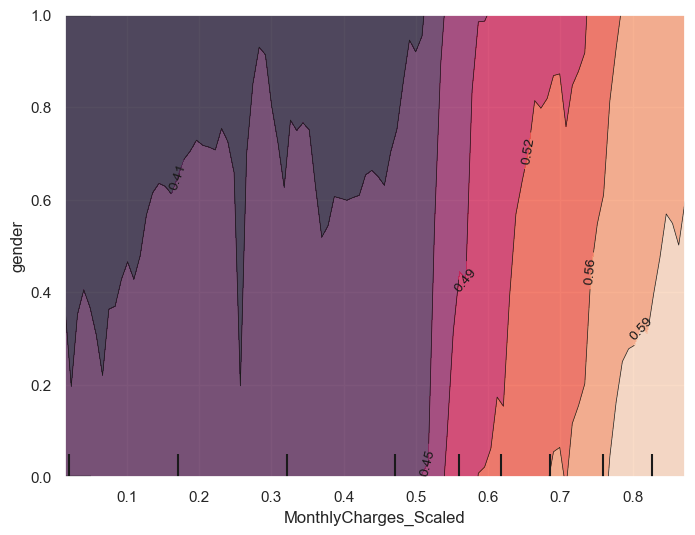

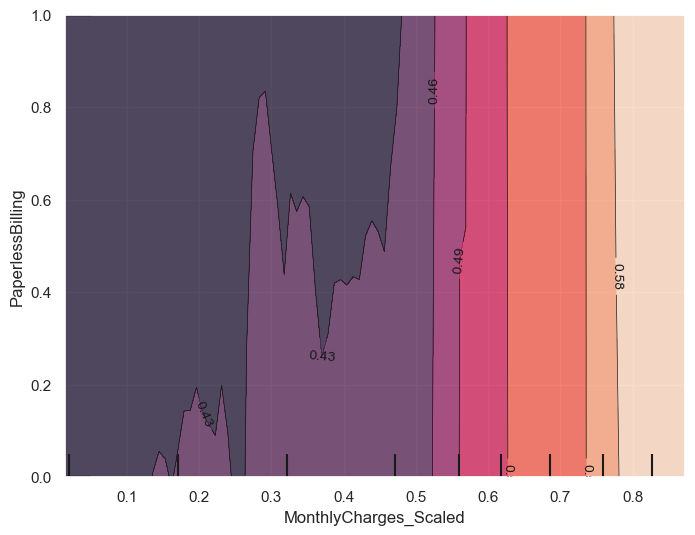

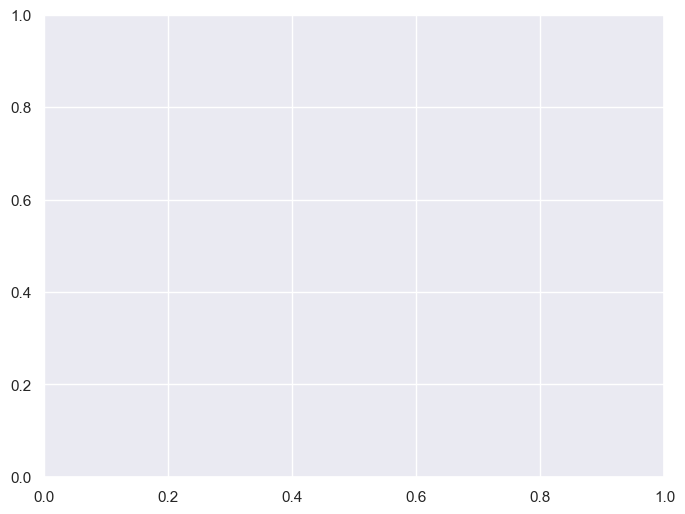

In [48]:
feature_names = [
    'Contract',
    'TechSupport',
    'OnlineSecurity',
    'OnlineBackup',
    'PaymentMethod',
    'DeviceProtection',
    'Dependents',
    'Partner',
    'InternetService',
    'gender',
    'PaperlessBilling',
    'PhoneService',
    'StreamingTV'
]

for i in feature_names:
    pdp_2D(i)

## Reference
https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea